In [1]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 19kB/s 
     |████████████████████████████████| 12.8MB 49.1MB/s 
     |████████████████████████████████| 7.6MB 6.0MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [2]:
# установка подходящей версии torch

from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [3]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
import PIL
print(PIL.__version__)

7.0.0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/ready_kt.zip -d train
# !unzip -q /content/gdrive/MyDrive/kt_test_data_test.zip -d test

Выходные данные были обрезаны до нескольких последних строк (5000).
Готовые снимки/опухоль/3D_MPR_-_ZHUKOV_M.S.‎_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0022.jpg:  mismatching "local" filename (╨У╨╛╤В╨╛╨▓╤Л╨╡ ╤Б╨╜╨╕╨╝╨║╨╕/╨╛╨┐╤Г╤Е╨╛╨╗╤М/3D_MPR_-_ZHUKOV_M.S.тАО_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0022.jpg),
         continuing with "central" filename version
Готовые снимки/опухоль/3D_MPR_-_ZHUKOV_M.S.‎_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0023.jpg:  mismatching "local" filename (╨У╨╛╤В╨╛╨▓╤Л╨╡ ╤Б╨╜╨╕╨╝╨║╨╕/╨╛╨┐╤Г╤Е╨╛╨╗╤М/3D_MPR_-_ZHUKOV_M.S.тАО_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0023.jpg),
         continuing with "central" filename version
Готовые снимки/опухоль/3D_MPR_-_ZHUKOV_M.S.‎_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0024.jpg:  mismatching "local" filename (╨У╨╛╤В╨╛╨▓╤Л╨╡ ╤Б╨╜╨╕╨╝╨║╨╕/╨╛╨┐╤Г╤Е╨╛╨╗╤М/3D_MPR_-_ZHUKOV_M.S.тАО_(34y)_-_02.10.2020_8_51_22_-_Head__1.5__H31s_0024.jpg),
         continuing with "central" filename version
Готовые снимки

In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Jan 17 12:16:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [8]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [10]:
class KTDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.crop((470, 0, 1449, 979))
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
import random

In [13]:
TRAIN_DIR = Path('train/Готовые снимки')
# TEST_DIR = Path('test/kt_test_data_test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
random.shuffle(train_val_files)
print(train_val_files)
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

[PosixPath('train/Готовые снимки/ВМГ_ВЖК/3D_MPR_-_USTALOV_E.YU.\u200e_(48y)_-_22.09.2020_10_04_00_-_Head__3.0__H31s_0045.jpg'), PosixPath('train/Готовые снимки/САК/3D_MPR_-_MASYUTIN_N_A\u200e_(62y)_-_30.09.2020_18_09_14_-__Head_0.5_0088.jpg'), PosixPath('train/Готовые снимки/ВМГ 2/3D_MPR_-_LEVINA_L_G\u200e_(48y)_-_01.10.2020_14_34_43_-__Head_0.5_0105.jpg'), PosixPath('train/Готовые снимки/ВМГ 2/3D_MPR_-_PONOMAREVA__A_M\u200e_(86y)_-_10.10.2020_2_27_07_-_Head__1.5__J30s_0098.jpg'), PosixPath('train/Готовые снимки/ВМГ 2/3D_MPR_-_STAFEEV_V._A.\u200e_(71y)_-_18.10.2020_11_41_53_-_Vol_1mm_Head_1.0__Native_Phase_Vol_1mm_0046.jpg'), PosixPath('train/Готовые снимки/ВМГ_ВЖК/3D_MPR_-_DITE_N_A\u200e_(65y)_-_04.10.2020_21_24_39_-_Head__1.5__J30s_0046.jpg'), PosixPath('train/Готовые снимки/САК_ВМГ/3D_MPR_-_CHERANEV_O.G.\u200e_(48y)_-_24.10.2020_17_46_18_-_Head__3.0__H31s_0155.jpg'), PosixPath('train/Готовые снимки/ВМГ 1/3D_MPR_-_MIKHAYLOV_YU_P\u200e_(50y)_-_11.10.2020_16_57_17_-__Head_0.5_0072.jpg'

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
print(train_val_labels)
print(len(train_val_labels))

['ВМГ_ВЖК', 'САК', 'ВМГ 2', 'ВМГ 2', 'ВМГ 2', 'ВМГ_ВЖК', 'САК_ВМГ', 'ВМГ 1', 'ВМГ 1', 'ВМГ 2', 'ВМГ 1', 'ВМГ 2', 'ВМГ 1', 'САК_ВЖК', 'САК_ВМГ', 'ВМГ 2', 'САК_ВМГ', 'ВМГ_ишемия', 'ВМГ 2', 'ВМГ 1', 'ВМГ_ВЖК', 'ишемия', 'ВМГ 2', 'опухоль', 'опухоль', 'ВМГ_ишемия', 'ВМГ 1', 'ВМГ 2', 'ВМГ 1', 'САК', 'ишемия', 'ВМГ_ВЖК', 'САК_ВЖК', 'ВМГ 2', 'ВЖК', 'ВМГ 1', 'ВМГ 2', 'ВМГ 2', 'ВМГ 1', 'ВМГ 2', 'САК', 'ВМГ 2', 'ВМГ_ВЖК', 'ВМГ 1', 'ВМГ_ВЖК', 'опухоль', 'ишемия', 'опухоль', 'ВМГ 2', 'ВМГ_ВЖК', 'САК_ВМГ', 'ишемия', 'ВМГ 2', 'САК', 'ВМГ_ВЖК', 'ВМГ 2', 'ВМГ 1', 'САК_ВМГ', 'ВМГ 1', 'САК', 'ВМГ 2', 'ВМГ 1', 'эд_сд', 'ВМГ 1', 'САК_ВМГ', 'ВМГ_ВЖК', 'ВМГ 1', 'ВМГ_ВЖК_САК', 'эд_сд', 'ВМГ 2', 'САК_ВЖК', 'ВМГ 1', 'опухоль', 'ВМГ_ВЖК', 'САК_ВМГ', 'ВМГ_ВЖК', 'опухоль', 'САК', 'ВМГ 2', 'эд_сд', 'САК_ВЖК', 'ВМГ_ишемия', 'САК_ВМГ', 'ишемия', 'ВМГ_ВЖК', 'ВМГ_ВЖК', 'ВЖК', 'САК_ВМГ', 'САК_ВЖК', 'ВМГ 1', 'ВМГ 1', 'ВМГ 1', 'САК', 'ВМГ 1', 'ВМГ 1', 'опухоль', 'ВМГ_ВЖК', 'ВМГ 2', 'ишемия', 'ВМГ 2', 'ВМГ 2', 'САК_ВМГ', 

In [15]:
val_dataset = KTDataset(val_files, mode='val')
print(len(val_dataset))

2809


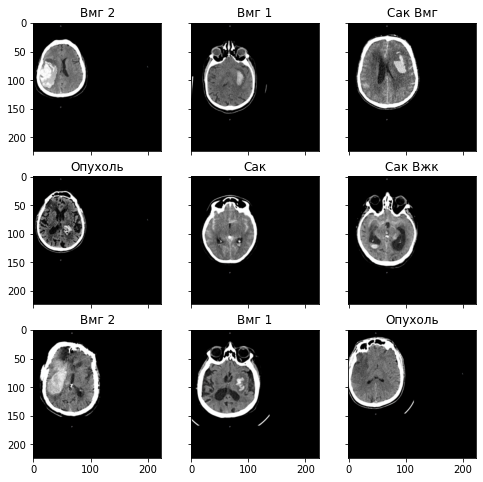

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [17]:
class SimpleCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [18]:
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [19]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [20]:
def macro_soft_f1(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    
    return macro_cost

In [21]:
from torchvision import datasets, models, transforms

num_classes=14
torch.manual_seed(42)
np.random.seed(42)

base_model=SimpleCnn(num_classes)

base_model=base_model.to(DEVICE)

loss_fn = f1_loss

optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-2)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        # print(inputs.shape)
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [23]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [24]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            torch.save(model.state_dict(), "gdrive/MyDrive/KT_base_"+str(epoch+1)+".pth")
    return history

In [25]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [26]:
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))
print(base_model)

we will classify :14
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [27]:
train_dataset = KTDataset(train_files, mode='train')

In [28]:
history = train(train_dataset, val_dataset, model=base_model, epochs=30, batch_size=64)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.8479941101785005


epoch:   3%|▎         | 1/30 [05:24<2:36:44, 324.29s/it]


Epoch 001 train_loss: 1.8480     val_loss 1.0883 train_acc 0.3522 val_acc 0.5977
loss 0.46926659599579684


epoch:   7%|▋         | 2/30 [10:47<2:31:10, 323.95s/it]


Epoch 002 train_loss: 0.4693     val_loss 0.1491 train_acc 0.8407 val_acc 0.9591
loss 0.09990031155984191


epoch:  10%|█         | 3/30 [16:06<2:25:03, 322.36s/it]


Epoch 003 train_loss: 0.0999     val_loss 0.1302 train_acc 0.9677 val_acc 0.9619
loss 0.06821815008657889


epoch:  13%|█▎        | 4/30 [21:23<2:19:01, 320.84s/it]


Epoch 004 train_loss: 0.0682     val_loss 0.0658 train_acc 0.9821 val_acc 0.9875
loss 0.04721560543361028


epoch:  17%|█▋        | 5/30 [26:40<2:13:10, 319.63s/it]


Epoch 005 train_loss: 0.0472     val_loss 0.1100 train_acc 0.9867 val_acc 0.9665
loss 0.05014463815548069


epoch:  20%|██        | 6/30 [31:55<2:07:20, 318.37s/it]


Epoch 006 train_loss: 0.0501     val_loss 0.0621 train_acc 0.9869 val_acc 0.9868
loss 0.03389708565259801


epoch:  23%|██▎       | 7/30 [37:11<2:01:45, 317.62s/it]


Epoch 007 train_loss: 0.0339     val_loss 0.0462 train_acc 0.9912 val_acc 0.9904
loss 0.027563101308959243


epoch:  27%|██▋       | 8/30 [42:26<1:56:09, 316.81s/it]


Epoch 008 train_loss: 0.0276     val_loss 0.0578 train_acc 0.9935 val_acc 0.9879
loss 0.03290950007547235


epoch:  30%|███       | 9/30 [47:25<1:49:03, 311.62s/it]


Epoch 009 train_loss: 0.0329     val_loss 0.0616 train_acc 0.9912 val_acc 0.9900
loss 0.025415779958633186


epoch:  33%|███▎      | 10/30 [52:01<1:40:13, 300.69s/it]


Epoch 010 train_loss: 0.0254     val_loss 0.0475 train_acc 0.9936 val_acc 0.9918
loss 0.037336151833486174


epoch:  37%|███▋      | 11/30 [56:34<1:32:37, 292.49s/it]


Epoch 011 train_loss: 0.0373     val_loss 0.0888 train_acc 0.9901 val_acc 0.9854
loss 0.03196954139597394


epoch:  40%|████      | 12/30 [1:01:06<1:25:56, 286.46s/it]


Epoch 012 train_loss: 0.0320     val_loss 0.0622 train_acc 0.9912 val_acc 0.9872
loss 0.03145880202539292


epoch:  43%|████▎     | 13/30 [1:05:37<1:19:49, 281.75s/it]


Epoch 013 train_loss: 0.0315     val_loss 0.0553 train_acc 0.9916 val_acc 0.9883
loss 0.02125881088390476


epoch:  47%|████▋     | 14/30 [1:10:08<1:14:15, 278.45s/it]


Epoch 014 train_loss: 0.0213     val_loss 0.0539 train_acc 0.9947 val_acc 0.9907
loss 0.0225992926509225


epoch:  50%|█████     | 15/30 [1:14:39<1:09:04, 276.32s/it]


Epoch 015 train_loss: 0.0226     val_loss 0.0561 train_acc 0.9944 val_acc 0.9890
loss 0.018514047756674173


epoch:  53%|█████▎    | 16/30 [1:19:11<1:04:08, 274.92s/it]


Epoch 016 train_loss: 0.0185     val_loss 0.0552 train_acc 0.9956 val_acc 0.9911
loss 0.020010017051479548


epoch:  57%|█████▋    | 17/30 [1:23:42<59:19, 273.82s/it]


Epoch 017 train_loss: 0.0200     val_loss 0.0586 train_acc 0.9950 val_acc 0.9915
loss 0.021439972828119574


epoch:  60%|██████    | 18/30 [1:28:14<54:37, 273.15s/it]


Epoch 018 train_loss: 0.0214     val_loss 0.0651 train_acc 0.9938 val_acc 0.9883
loss 0.024603986082063163


epoch:  63%|██████▎   | 19/30 [1:32:45<49:58, 272.56s/it]


Epoch 019 train_loss: 0.0246     val_loss 0.0446 train_acc 0.9935 val_acc 0.9890
loss 0.020466200086986037


epoch:  67%|██████▋   | 20/30 [1:37:16<45:20, 272.06s/it]


Epoch 020 train_loss: 0.0205     val_loss 0.0551 train_acc 0.9944 val_acc 0.9900
loss 0.02110593884450744


epoch:  70%|███████   | 21/30 [1:41:47<40:45, 271.69s/it]


Epoch 021 train_loss: 0.0211     val_loss 0.0539 train_acc 0.9943 val_acc 0.9907
loss 0.022616764805537207


epoch:  73%|███████▎  | 22/30 [1:46:17<36:10, 271.33s/it]


Epoch 022 train_loss: 0.0226     val_loss 0.0437 train_acc 0.9942 val_acc 0.9925
loss 0.016631546342860817


epoch:  77%|███████▋  | 23/30 [1:50:47<31:36, 270.97s/it]


Epoch 023 train_loss: 0.0166     val_loss 0.0545 train_acc 0.9956 val_acc 0.9900
loss 0.01840630948200133


epoch:  80%|████████  | 24/30 [1:55:22<27:11, 272.00s/it]


Epoch 024 train_loss: 0.0184     val_loss 0.0444 train_acc 0.9950 val_acc 0.9929
loss 0.014391177233972615


epoch:  83%|████████▎ | 25/30 [1:59:56<22:44, 272.82s/it]


Epoch 025 train_loss: 0.0144     val_loss 0.0478 train_acc 0.9962 val_acc 0.9900
loss 0.019262439801775267


epoch:  87%|████████▋ | 26/30 [2:04:28<18:10, 272.57s/it]


Epoch 026 train_loss: 0.0193     val_loss 0.0442 train_acc 0.9943 val_acc 0.9900
loss 0.016321581106448584


epoch:  90%|█████████ | 27/30 [2:09:03<13:39, 273.12s/it]


Epoch 027 train_loss: 0.0163     val_loss 0.0285 train_acc 0.9951 val_acc 0.9939
loss 0.01798000774497607


epoch:  93%|█████████▎| 28/30 [2:13:35<09:05, 272.92s/it]


Epoch 028 train_loss: 0.0180     val_loss 0.0535 train_acc 0.9948 val_acc 0.9907
loss 0.017009012454393065


epoch:  97%|█████████▋| 29/30 [2:18:17<04:35, 275.46s/it]


Epoch 029 train_loss: 0.0170     val_loss 0.0470 train_acc 0.9962 val_acc 0.9915
loss 0.023372495440386436


epoch: 100%|██████████| 30/30 [2:23:17<00:00, 286.59s/it]


Epoch 030 train_loss: 0.0234     val_loss 0.0617 train_acc 0.9943 val_acc 0.9893


In [29]:
loss, acc, val_loss, val_acc = zip(*history)

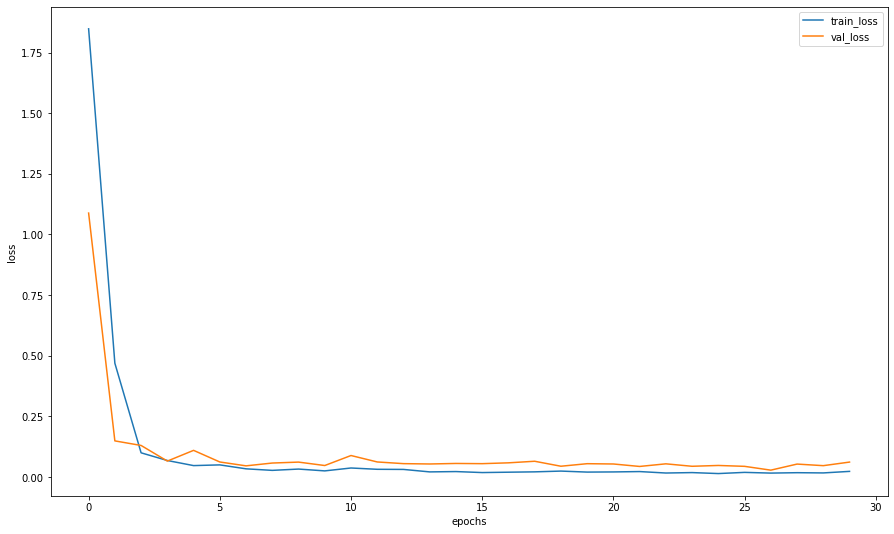

In [30]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model.load_state_dict(torch.load(".pth"))

In [31]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [32]:
random_characters = int(np.random.uniform(0,2808))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(base_model, ex_img.unsqueeze(0))

In [33]:
idxs = list(map(int, np.random.uniform(0,2808,3)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(base_model, imgs)

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [35]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [36]:
actual_labels=[label_encoder.classes_[i] for i in actual_labels]
print(actual_labels)
print(y_pred)
print(preds_class)

['опухоль', 'САК', 'ВМГ_ВЖК']
[12  7  3]
['опухоль', 'САК', 'ВМГ_ВЖК']


In [37]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average=None)


array([1., 1., 1.])

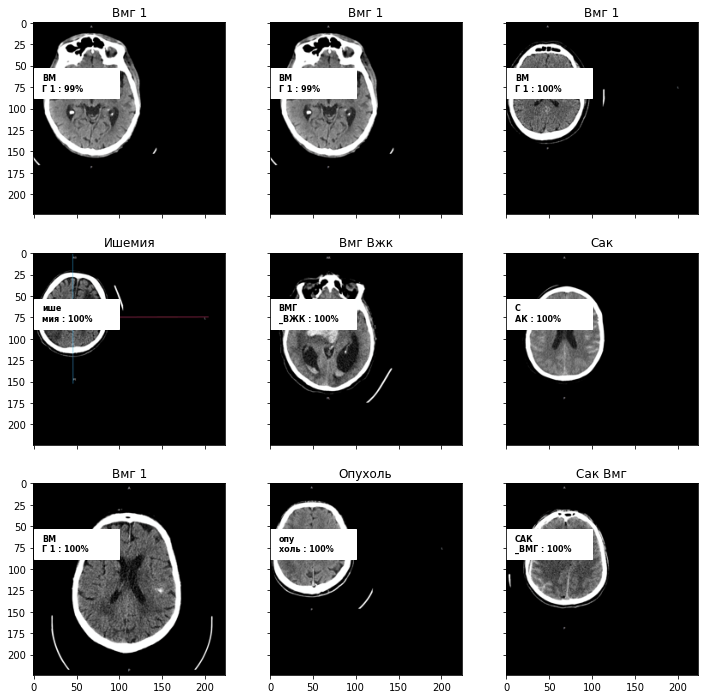

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,2808))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),100,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    prob_pred = predict_one_sample(base_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(10, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')